In [44]:
from model import *
from coco_class import *
from resnet_stuff import get_resnet
from train_model import *
import matplotlib.pyplot
%matplotlib notebook
import pickle
import numpy as np
import mygrad as mg
import random

from mynn.optimizers.sgd import SGD
from mynn.optimizers.adam import Adam

from noggin import create_plot
from itertools import chain
from collections import Counter

In [3]:
captions = np.array(list(caption_ids_to_captions_dict.values()))
captions = captions.flatten()
counter = Counter()

N = len(captions)

for c in captions:
    counter.update(set(strip_punc(c).lower().split()))

idf_dict = {word: np.log10(N/freq) for word, freq in counter.items()}

In [4]:
glove = get_glove(r"/Users/sophiachen/Downloads/glove.6B.200d.txt.w2v")
glove_shape = glove["word"].shape

In [5]:
file_path = "/Users/sophiachen/Downloads/resnet18_features.pkl"
resnet18_features = get_resnet(file_path)

# All the image ids and descriptors in the resnet18 dataset
resnet18_features_ids = list(resnet18_features.keys())
resnet18_features_descriptors = list(resnet18_features.values())

n = 1 # tournament size for confusor id generation
# good_caption_ids, good_img_ids, bad_image_ids = list(zip(batch_triples))
training_data_triplets, validation_data_triplets = generate_train_data(resnet18_features, idf_dict, n, glove, glove_shape)

In [50]:
class Model:
    def __init__(self, dim_input, dim_output):
        self.W_embed = dense(
            dim_input, 
            dim_output, 
            weight_initializer=glorot_normal, 
            bias=False
        )

    def __call__(self, x):
        w = self.W_embed(x)
        w = w.reshape(-1, 200)
        return w / mg.sqrt(mg.einsum("nd, nd -> n", w, w)).reshape(-1, 1)

    def save_params(self, file_path):
        with open(file_path, mode="wb") as opened_file:
            for x in self.parameters():
                np.savez(opened_file, x.data)

    def load_params(self, file_path):
        with open(file_path,mode="rb") as opened_file:
            saved_params = np.load(opened_file)
            self.parameters.data = saved_params
    @property
    def parameters(self):
        return self.W_embed.parameters

<IPython.core.display.Javascript object>


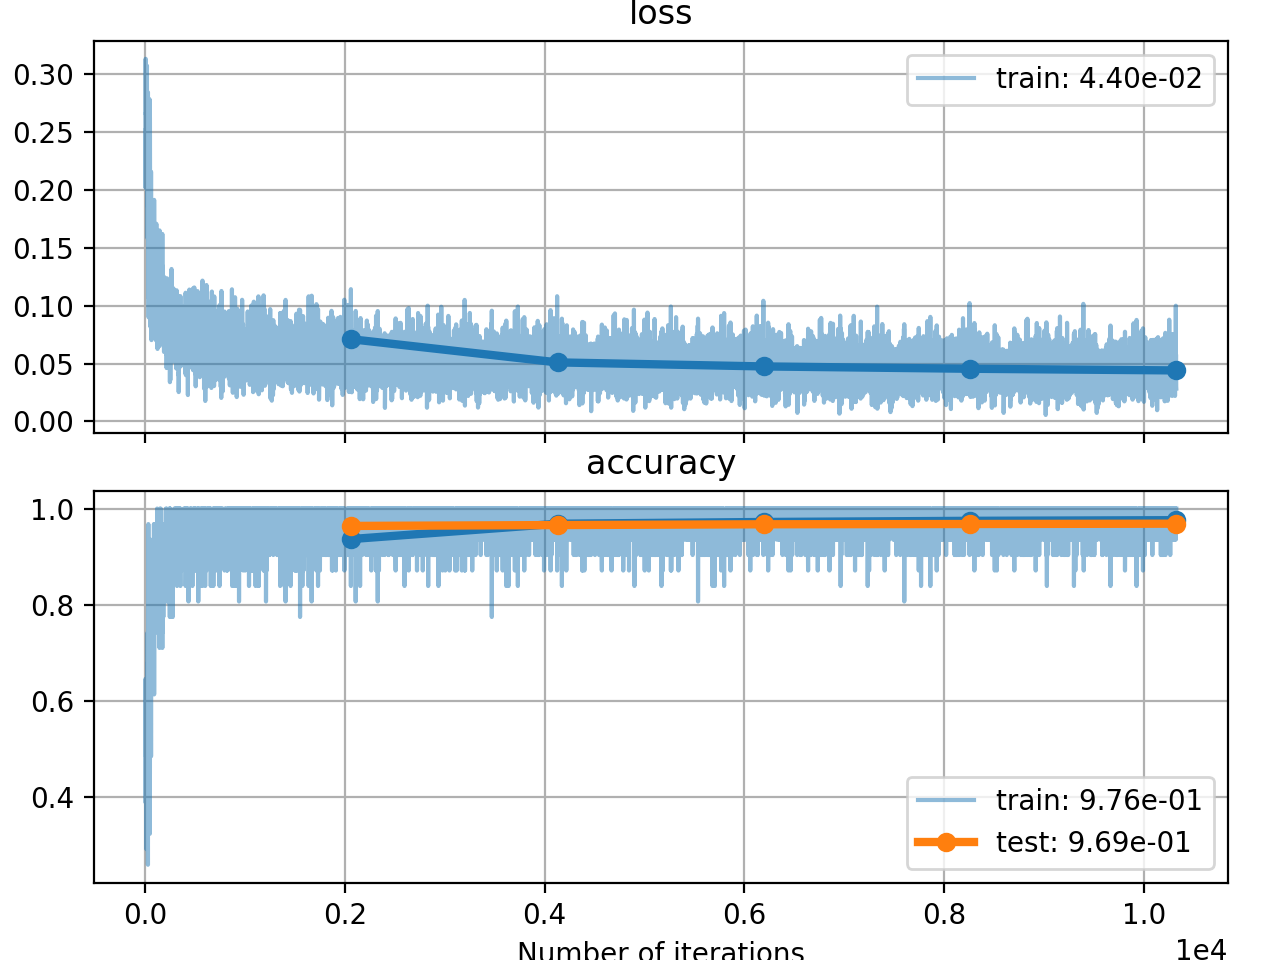

In [51]:
model = Model(512, 200)
num_epochs = 5
batch_size = 32
optimizer = Adam(model.parameters,learning_rate=1e-3)
margin = 0.25

# setting up a noggin plot

plotter, fig, ax = create_plot(["loss", "accuracy"])

In [52]:
for epoch in range(num_epochs):
    # Indexing the tuple of the training data triplets
    # Training data triplets are not individual
    w_captions = training_data_triplets[0]
    d_imgs = training_data_triplets[1]
    d_confusors = training_data_triplets[2]
    
    for batch_cnt in range(0, len(training_data_triplets[0]) // batch_size):
        batch_indices = np.arange(batch_cnt * batch_size, ((batch_cnt + 1) * batch_size)-1)
        
        # Creating batches of training data
        batch_w_captions = w_captions[batch_indices]
        batch_d_img = d_imgs[batch_indices]
        batch_d_confusor = d_confusors[batch_indices]
        
        # Forward pass
        w_img = model(batch_d_img)
        w_confusor = model(batch_d_confusor)
        
        # Compute error
        sim_match = compute_cos_dist(w_img, batch_w_captions)
        sim_confuse = compute_cos_dist(w_confusor, batch_w_captions)
        loss = margin_ranking_loss(sim_match, sim_confuse,1,margin)

        # Backprop + gradient step
        loss.backward()
        optimizer.step()

        # Accuracy calculation
        acc = mg.mean(sim_match>sim_confuse)
        
        #acc = sum([1 for sm, sc in zip(sim_match, sim_confuse) if sm > sc])

        plotter.set_train_batch({"loss": loss.item(), "accuracy": acc}, batch_size=batch_size)
        mg.turn_memory_guarding_off()
    
    #unpack validation data
    test_w_captions, test_d_imgs, test_d_confusors = validation_data_triplets
    N_test = validation_data_triplets[0].shape[0]

    for batch_cnt in range(0, N_test //batch_size):

        batch_indices = np.arange(batch_cnt * batch_size, ((batch_cnt + 1) * batch_size)-1)
        
        # Creating batches of validation data
        batch_w_captions = test_w_captions[batch_indices]
        batch_d_img = test_d_imgs[batch_indices]
        batch_d_confusor = test_d_confusors[batch_indices]

        with mg.no_autodiff:
            test_w_img = model(batch_d_img)
            test_w_confusor = model(batch_d_confusor)

            test_sim_match = compute_cos_dist(test_w_img, batch_w_captions)
            test_sim_confuse = compute_cos_dist(test_w_confusor, batch_w_captions)
            test_acc = mg.mean(test_sim_match>test_sim_confuse)
            #test_acc = sum([1 for sm, sc in zip(test_sim_match, test_sim_confuse) if sm > sc]) / test_w_captions.shape[0]
    
        plotter.set_test_batch({"accuracy" : test_acc}, batch_size=batch_size)
    
    plotter.set_train_epoch()
    plotter.set_test_epoch()
plotter.plot()
